In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [28]:
train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
original = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

In [29]:
original['Depression'] = original['Depression'].map({"Yes": 1, "No": 0})

df = pd.concat([train, original], ignore_index=True)

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

for col in test.select_dtypes(include='object').columns:
    test[col] = test[col].astype('category')

X = df.drop('Depression', axis=1)
Y = df['Depression']


In [30]:
df.head()


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0.0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1.0,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2.0,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3.0,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4.0,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


# Imbalanced Data

In [31]:
df['Depression'].value_counts()

Depression
0    117234
1     26022
Name: count, dtype: int64

# EDA

**Gender vs Depression**

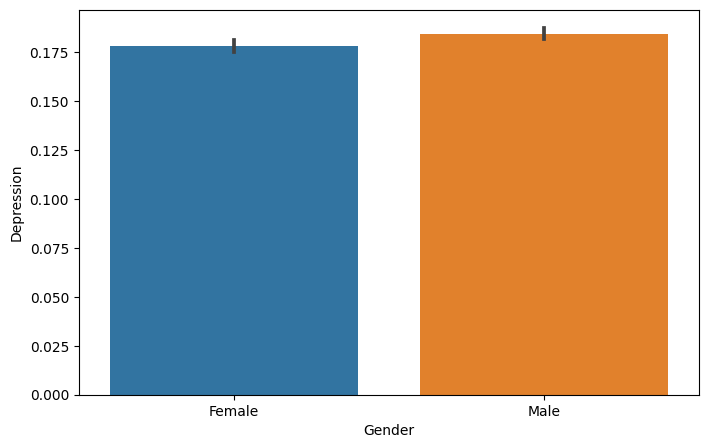

In [32]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['Gender'], y=df['Depression'])
plt.show()

> The chart shows that both genders experience similar levels of depression, with a slightly higher average for males. This indicates that, on average, depression levels do not vary significantly by gender in this dataset

**2) City vs Depression**

> There are total of 98 Unique cities

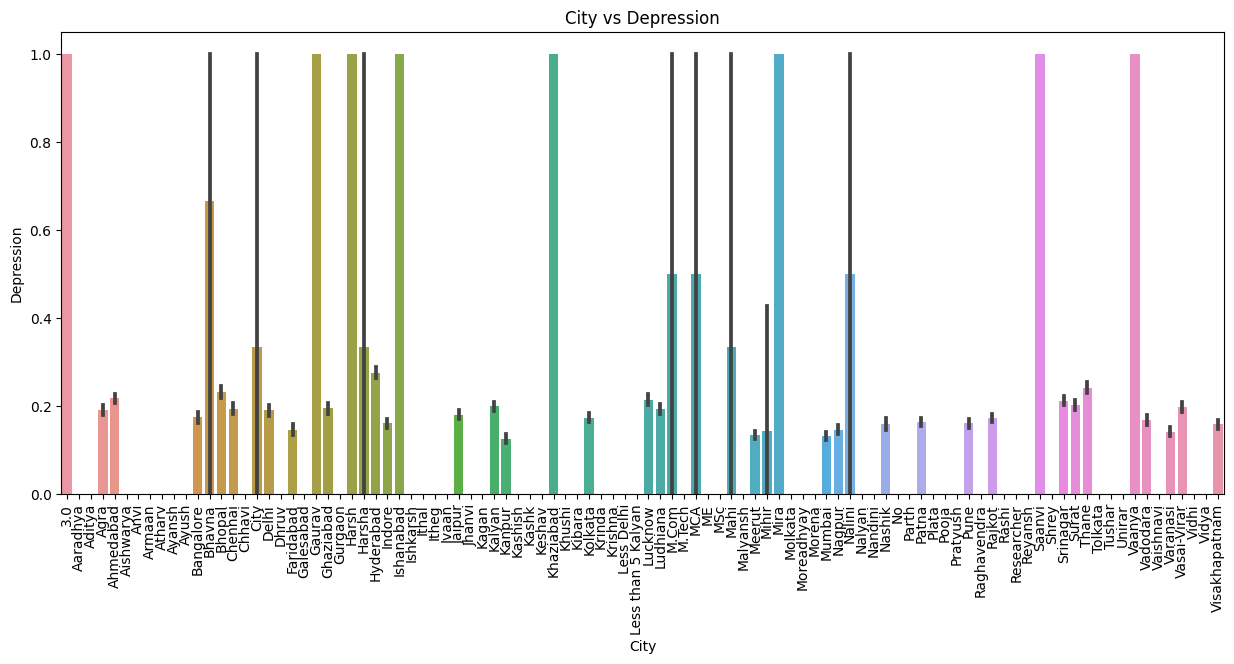

In [33]:
plt.figure(figsize=(15,6))
sns.barplot(x='City', y='Depression', data=df)
plt.xticks(rotation=90)
plt.title('City vs Depression')
plt.show()

> The chart indicates that average depression levels vary widely across cities, with certain areas showing higher scores. This could suggest that location-specific factors may influence depression, though further analysis would be required to understand these differences fully

**3) Working Professional or Student vs Depression**

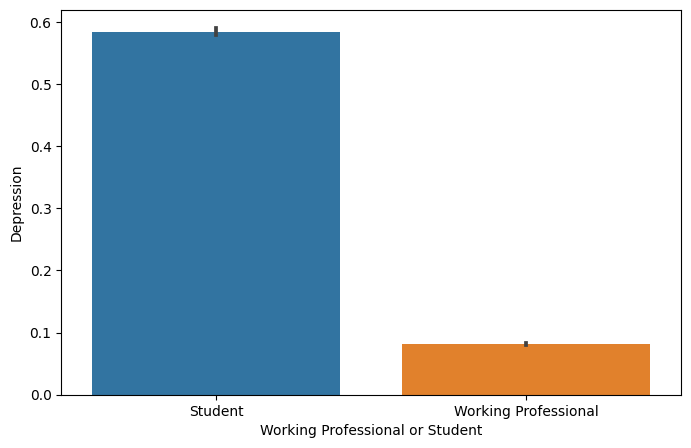

In [34]:
plt.figure(figsize=(8,5))
sns.barplot(x='Working Professional or Student', y='Depression', data=df)
plt.show()

> The data clearly indicates that students experience higher levels of depression compared to working professionals. Let's investigate the possible reasons behind this difference.

**4) Profession vs Depression**

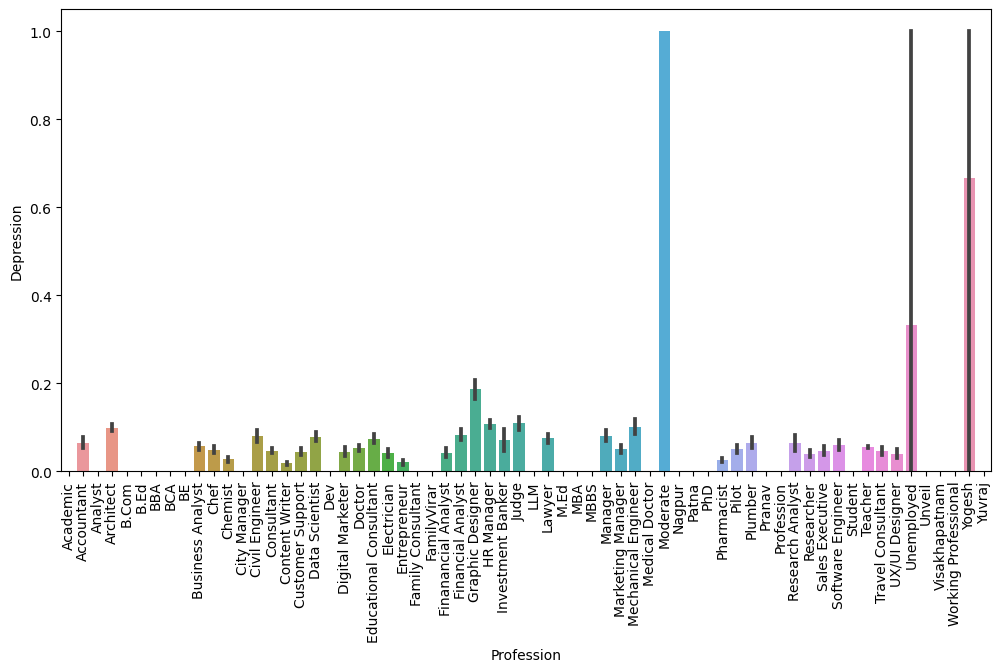

In [35]:
plt.figure(figsize=(12,6))
sns.barplot(x='Profession', y='Depression', data=df)
plt.xticks(rotation=90)
plt.show()

> Unemployed individuals show higher levels of depression, along with a few other professions that might be misclassified in this dataset. It appears that individuals with more unstructured time may be more prone to depressive thoughts compared to those who are occupied with work, as they may lack the mental engagement that comes with a busy schedule. This aligns with the saying, 'An idle mind is the devil's workshop

**5) Age vs Depression**

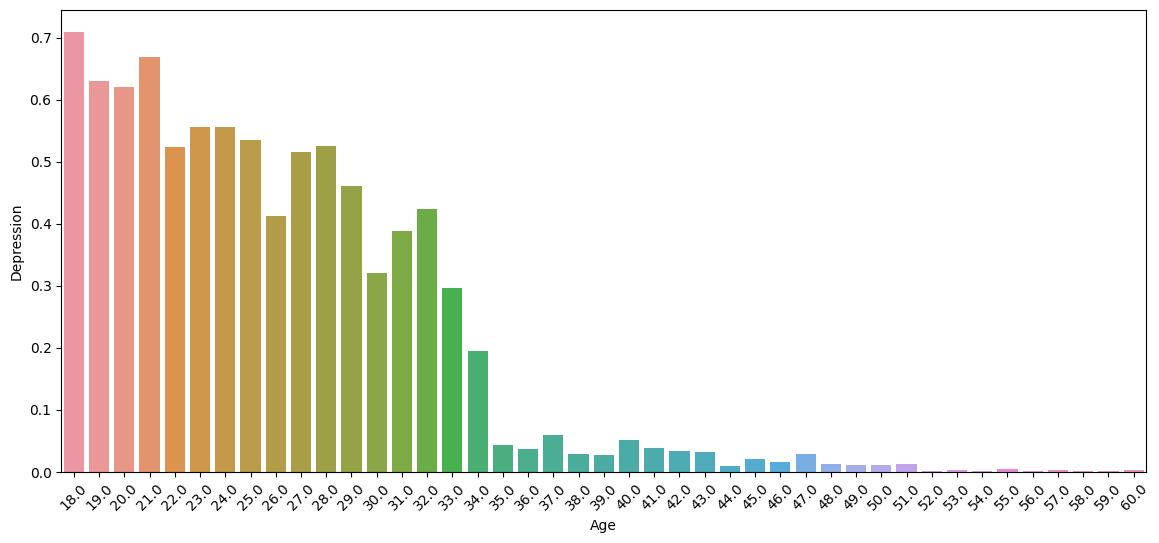

In [36]:
plt.figure(figsize=(14,6))
Age_depression_proportion = df.groupby('Age')['Depression'].mean().reset_index()
sns.barplot(x='Age', y='Depression', data=Age_depression_proportion)
plt.xticks(rotation=45)
plt.show()

> This data indicates that younger individuals are more susceptible to depression than older ones. As age increases, levels of depression tend to decrease, suggesting a negative correlation between age and depression. This trend may reflect various factors, younger people often face unique stressors related to academic, career, and social pressures, which can contribute to higher rates of depression. Older individuals, on the other hand, might have greater life stability, more coping mechanisms, and a stronger sense of self, which could buffer against depressive symptoms. Understanding these trends could help in tailoring mental health interventions for different age groups.

**6) Academic Pressure vs Depression**

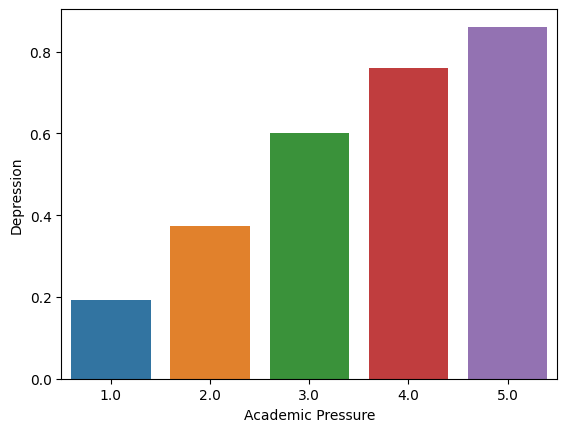

In [37]:
depression_proportion = df.groupby('Academic Pressure')['Depression'].mean().reset_index()
sns.barplot(x='Academic Pressure', y='Depression', data=depression_proportion)
plt.show()

> Based on the chart, there is a clear positive correlation between academic pressure and depression levels. As academic pressure increases, the average depression score also rises, suggesting that higher academic demands may be associated with increased mental health challenges among students.

**7) Work Pressure vs Depression**

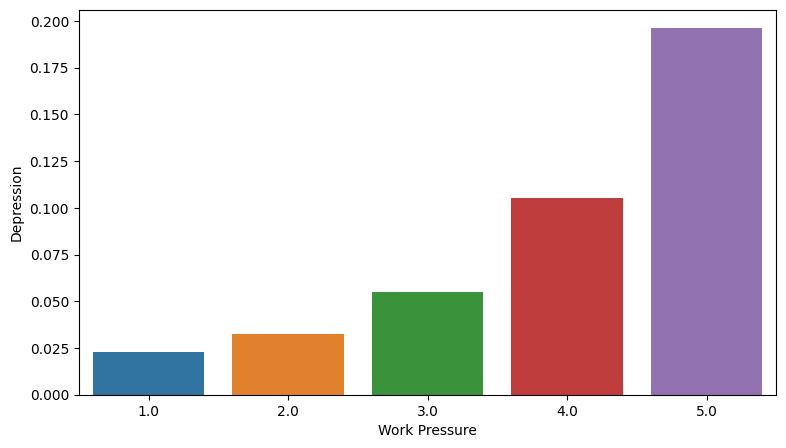

In [38]:
plt.figure(figsize=(9,5))
work_pressure_depression_proportion = df.groupby('Work Pressure')['Depression'].mean().reset_index()
sns.barplot(x='Work Pressure', y='Depression', data=work_pressure_depression_proportion)
plt.show()

> The bar chart illustrates a positive correlation between work pressure and depression levels. As work pressure increases, employees tend to experience higher levels of depression. This trend is comparable to patterns observed in academic pressure, where increasing demands can lead to mental health challenges. High work pressure often results from employees being assigned workloads beyond their capacity, limiting their ability to engage in social activities or personal time. This lack of balance can exacerbate feelings of isolation and stress, further impacting mental well-being.

**8) CGPA vs Depression**

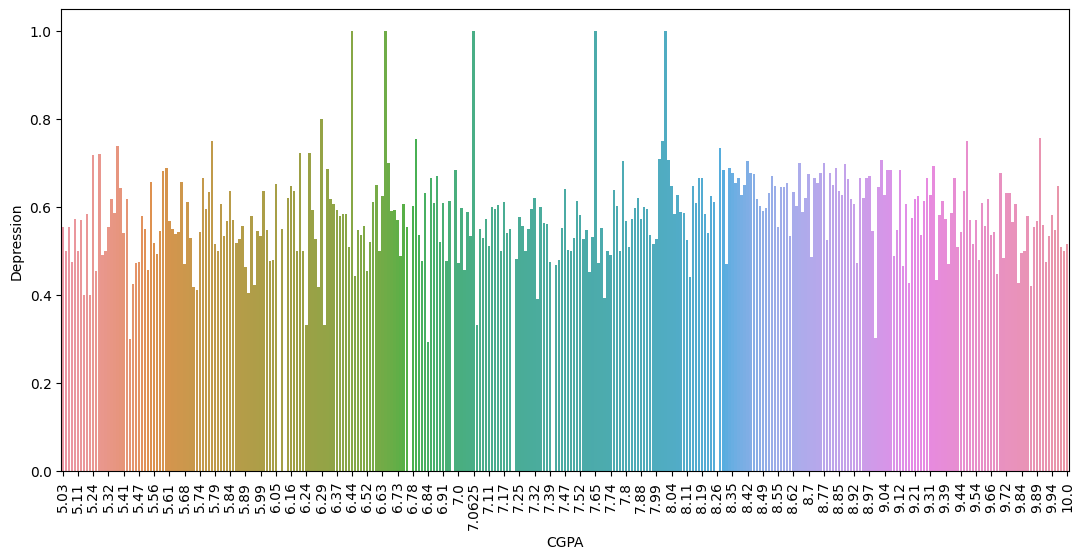

In [39]:
plt.figure(figsize=(13,6))
CGPA_proportion = df.groupby('CGPA')['Depression'].mean().reset_index()
sns.barplot(x='CGPA', y='Depression', data=CGPA_proportion)
plt.xticks(ticks=CGPA_proportion.index[::5], labels=CGPA_proportion['CGPA'][::5], rotation=90)
plt.show()

> The chart indicates that depression levels vary across CGPA ranges, without a clear linear trend. Students with both high and low CGPAs show notable levels of depression, suggesting that factors beyond academic performance, such as academic pressure or personal challenges, may influence depression across the spectrum of CGPA values.

**9) Study Satisfaction vs Depression**

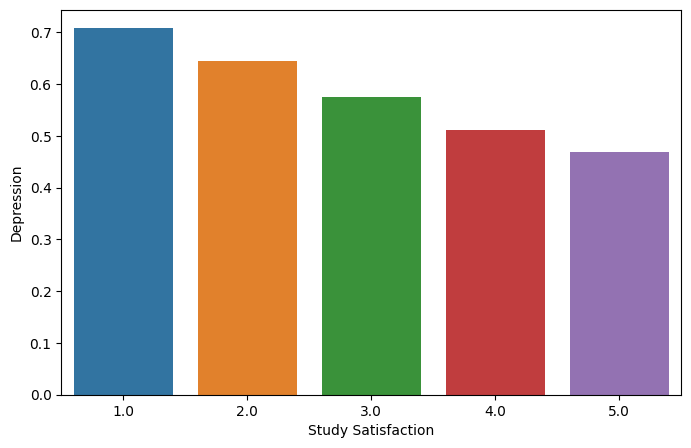

In [40]:
plt.figure(figsize=(8,5))
study_proportion = df.groupby('Study Satisfaction')['Depression'].mean().reset_index()
sns.barplot(x='Study Satisfaction', y='Depression', data=study_proportion)
plt.show()

We can see a beautfil negative correlation, where a student satisfaction on study decreases the Depression. Well it is true, if we look at students who dont study and on exam time they start studying trying to cover the whole syllabus in one night, taking pressure, gets depressed and also fails.

**10) Sleep Duration vs Depression**

> The data descriptions for "Sleep Duration" are indeed inconsistent and misleading, as they include unrelated or ambiguous categories. This makes it difficult to interpret which sleep duration correlates with higher depression levels accurately

> So I grouped them into categories, but still there is ambiguity in the data.

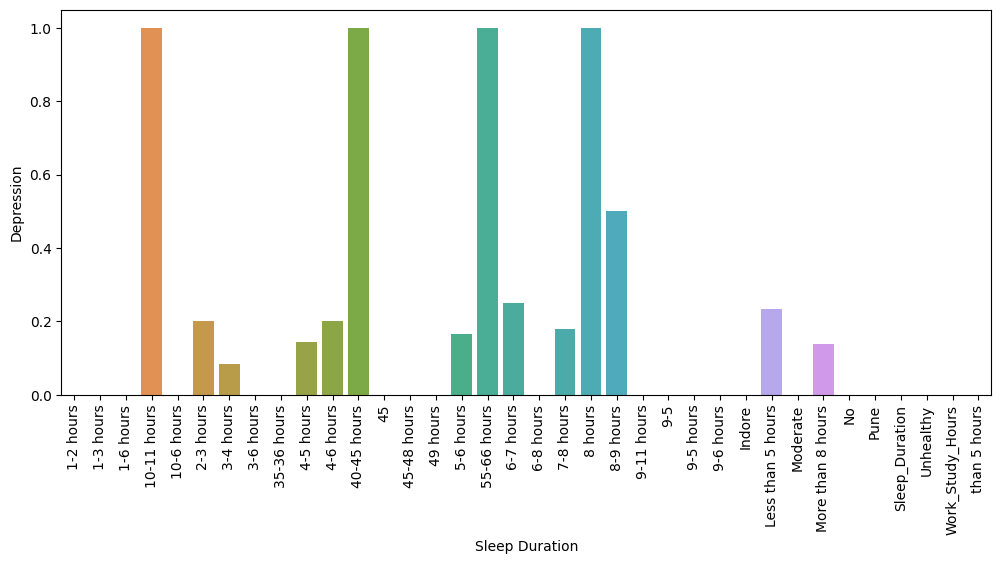

In [41]:
plt.figure(figsize=(12,5))
sleep_proportion = df.groupby('Sleep Duration')['Depression'].mean().reset_index()
sns.barplot(x='Sleep Duration', y='Depression', data=sleep_proportion)
plt.xticks(ticks=sleep_proportion.index[::1], labels=sleep_proportion['Sleep Duration'][::1], rotation=90)
plt.show()

> The chart suggests an inconsistent pattern in the relationship between sleep duration and depression levels. Although 8 hours of sleep shows a significant peak in depression, other durations do not follow a clear trend. Additionally, some categories overlap or seem unclear (e.g., "9-6 hours," "9-5," and ">8 hours"), which complicates the interpretation.

**11) Job Satisfaction vs Depression**

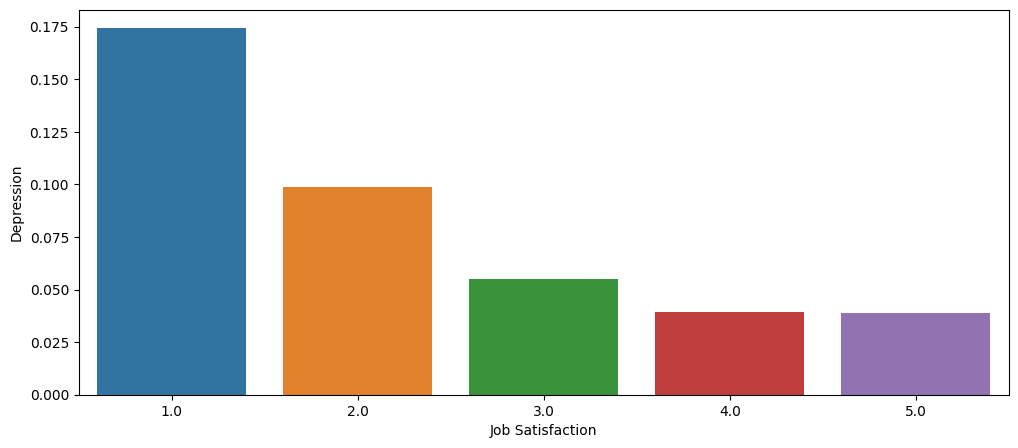

In [42]:
plt.figure(figsize=(12,5))
job_proportion = df.groupby('Job Satisfaction')['Depression'].mean().reset_index()
sns.barplot(x='Job Satisfaction', y='Depression', data=job_proportion)
plt.xticks(ticks=job_proportion.index[::1], labels=job_proportion['Job Satisfaction'][::1] )
plt.show()

> The chart shows a negative relationship between job satisfaction and depression levels. Higher job satisfaction scores (from 1 to 5) are associated with lower average depression levels. This suggests that individuals with higher job satisfaction tend to report fewer depression symptoms, highlighting the potential impact of job satisfaction on mental well-being.

**12) Dietary Habits vs Depression**

Data contains unnecassry data, labelled ambigious data with none 

In [43]:
irrelevant_labels_for_dietary = [ "Yes", "Pratham" ,"BSc", "Gender", "M.Tech" ,"Male", "Indoor", "Class 12", "Vegas", "No", "2","Mihir","1.0", "3"]
df['Dietary Habits'] = df['Dietary Habits'].replace(irrelevant_labels_for_dietary, "None")

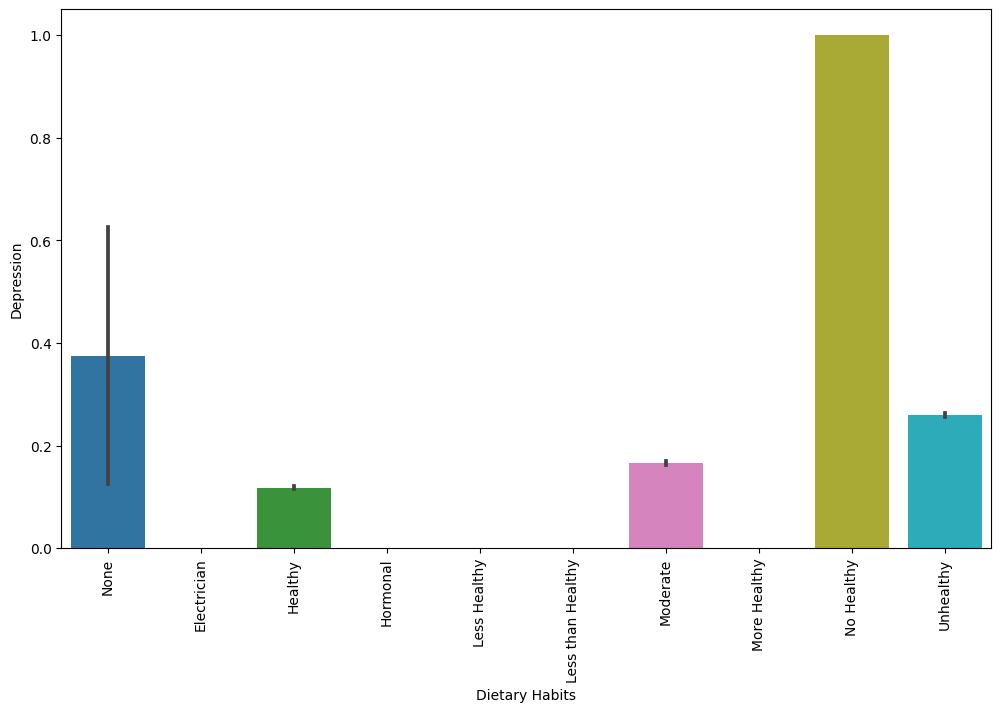

In [44]:
plt.figure(figsize=(12,7))
sns.barplot(x='Dietary Habits', y='Depression', data=df)
plt.xticks(rotation=90)
plt.show()

> Based on the chart, it appears that depression levels vary across dietary habits. Healthier dietary choices correlate with lower average depression scores, while moderate and unhealthy diets are associated with slightly higher depression levels

**13) Degree vs Depression**

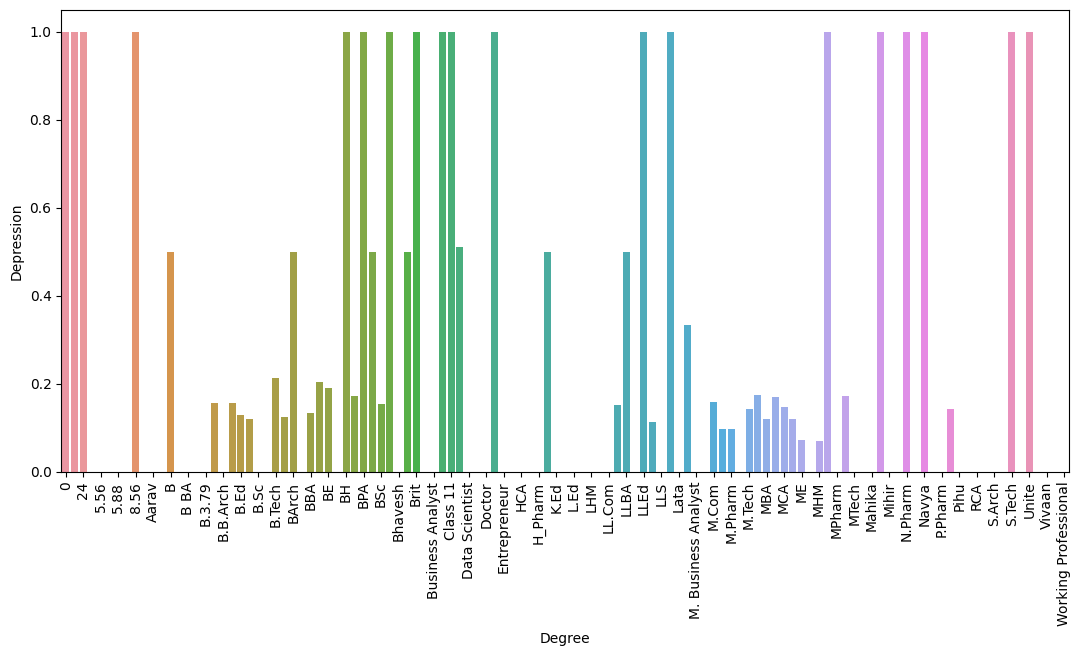

In [45]:
plt.figure(figsize=(13,6))
Degree_proportion = df.groupby('Degree')['Depression'].mean().reset_index()
sns.barplot(x='Degree', y='Depression', data=Degree_proportion)
plt.xticks(ticks=Degree_proportion.index[::2], labels=Degree_proportion['Degree'][::2], rotation=90)
plt.show()

> Alot of mislablled data is present, makes it very hard to interpret the data

**14) Have you ever had suicidal thoughts ?**

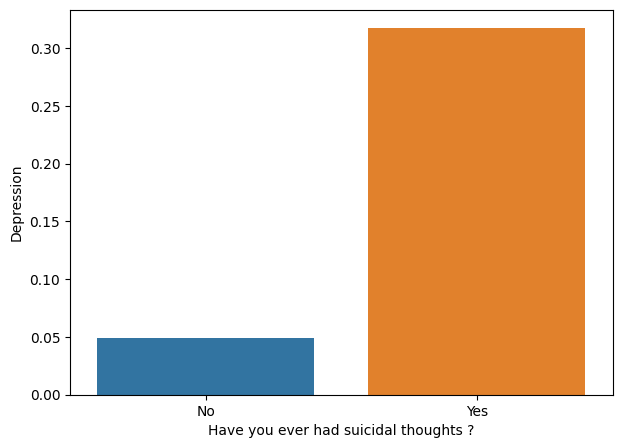

In [46]:
plt.figure(figsize=(7,5))
suicidal_proportion = df.groupby('Have you ever had suicidal thoughts ?')['Depression'].mean().reset_index()
sns.barplot(x='Have you ever had suicidal thoughts ?', y='Depression', data=suicidal_proportion)
plt.show()

**15) Work/Study Hours**

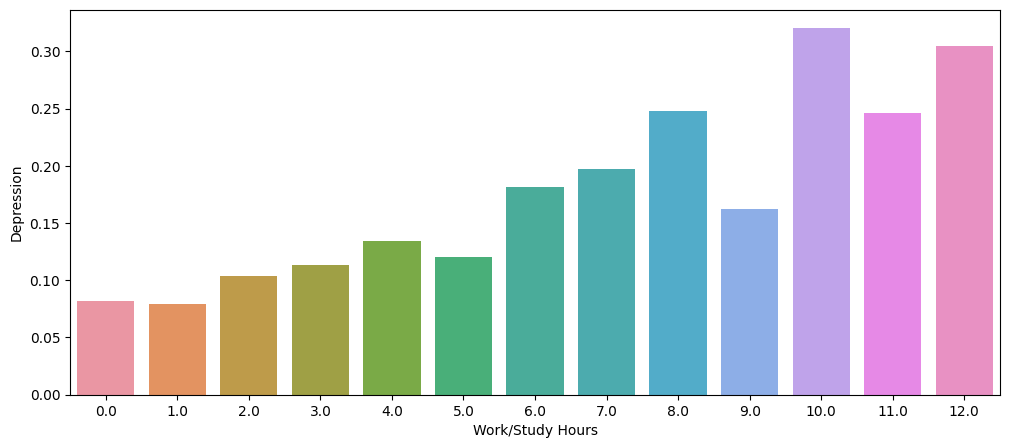

In [47]:
plt.figure(figsize=(12,5))
work_proportion = df.groupby('Work/Study Hours')['Depression'].mean().reset_index()
sns.barplot(x='Work/Study Hours', y='Depression', data=work_proportion)
plt.xticks(ticks=work_proportion.index[::1], labels=work_proportion['Work/Study Hours'][::1] )
plt.show()

> quite Amazing! The amount of study/work increase, the depression also increases. Should people study/ work less? will that cure there depression? what else PRODUCTIVE a person can do other than study? learning something grows an individually.

**16) Financial Stress**

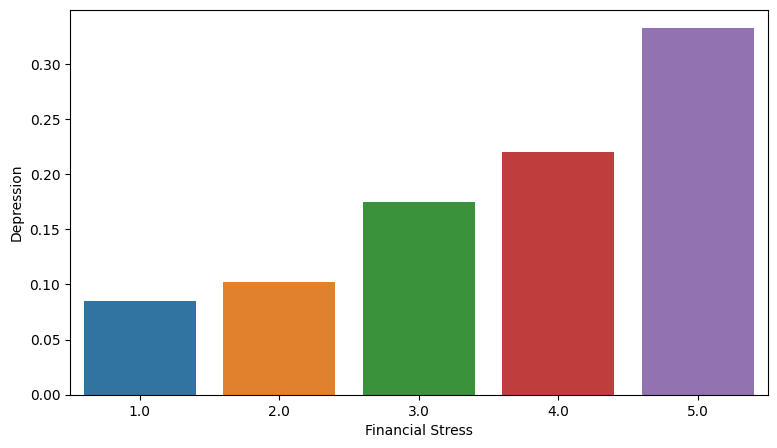

In [48]:
plt.figure(figsize=(9,5))
FinancialStress_proportion = df.groupby('Financial Stress')['Depression'].mean().reset_index()
sns.barplot(x='Financial Stress', y='Depression', data=FinancialStress_proportion)
plt.xticks(ticks=FinancialStress_proportion.index[::1], labels=FinancialStress_proportion['Financial Stress'][::1] )
plt.show()

> chart makes a clear cut sense! As an individual struggles financially, the depression tends to increase, when it is hard for thier needs to be fullfilled

**17) Family History of Mental Illness**

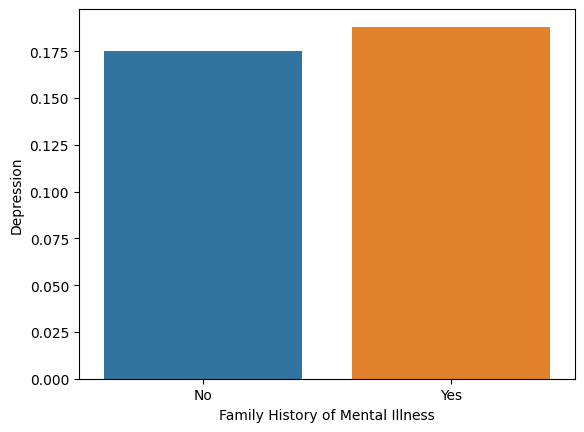

In [49]:
Mental_Illness_proportion = df.groupby('Family History of Mental Illness')['Depression'].mean().reset_index()
sns.barplot(x='Family History of Mental Illness', y='Depression', data=Mental_Illness_proportion)
plt.xticks(ticks=Mental_Illness_proportion.index[::1], labels=Mental_Illness_proportion['Family History of Mental Illness'][::1])
plt.show()


# baseline

In [50]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, train_size=0.8, random_state=42)

model = lgb.LGBMClassifier(verbose=-1)

model.fit(X_train, Y_train)

train_predictions = model.predict(X_train)
training_acc = accuracy_score(Y_train, train_predictions)
print(f'Training accuracy: {training_acc}')

prediction_score = model.predict(X_dev)

dev_acc = accuracy_score(Y_dev, prediction_score)
print(f'Dev accuracy: {dev_acc}')

Training accuracy: 0.9590677463264807
Dev accuracy: 0.938608125087254


**LeaderBoard Score: 0.94040**

# Now lets refine our Model

In [51]:
# def objective(trial):
#     # Define the parameters to optimize
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 2, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'n_estimators': trial.suggest_int('n_estimators', 350, 1000),
#         'num_leaves': trial.suggest_int('num_leaves', 5, 50),
#         'subsample': trial.suggest_float('subsample', 0, 1),
#         'lambda_l2': trial.suggest_float('lambda_l2',  0, 4),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
#         'verbosity': -1
#     }

#     # Initialize the model with the suggested parameters
#     model = lgb.LGBMClassifier(**params)

#     # Initialize StratifiedKFold
#     kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
#     accuracy_scores = []  # To store accuracy for each fold

#     # Cross-validation
#     for train_idx, test_idx in kfold.split(X, Y):
#         X_train, X_dev = X.iloc[train_idx], X.iloc[test_idx]
#         Y_train, Y_dev = Y.iloc[train_idx], Y.iloc[test_idx]

#         model = clone(lgb.LGBMClassifier(**params))  # Clone the model with the current parameters
#         model.fit(X_train, Y_train)  # Train the model

#         # Predict on the development set
#         prediction = model.predict(X_dev)
        
#         # Calculate accuracy
#         accuracy = accuracy_score(Y_dev, prediction)
#         accuracy_scores.append(accuracy)

#     # Return the mean accuracy across all folds
#     return np.mean(accuracy_scores)

# # Create an Optuna study to maximize the objective
# study = optuna.create_study(direction='maximize')

# # Optimize the objective function
# study.optimize(objective, n_trials=100)

# # Print the best parameters found
# print(f'Best Parameters: {study.best_params}')

# # Extract the best parameters
# best_params = study.best_params


In [52]:
params = {'max_depth': 10, 'learning_rate': 0.09035696113725614, 'n_estimators': 546, 'num_leaves': 8, 'subsample': 0.9184303358960701,
          'lambda_l2': 3.6809916176520234, 'colsample_bytree': 0.18108283990213297}

model = lgb.LGBMClassifier(**params, verbosity=-1)

print(X.dtypes[X.dtypes == 'object'])

model.fit(X_train, Y_train)

train_predictions = model.predict(X_train)
training_acc = accuracy_score(Y_train, train_predictions)
print(f'Training accuracy: {training_acc}')

prediction_score = model.predict(X_dev)

dev_acc = accuracy_score(Y_dev, prediction_score)
print(f'Dev accuracy: {dev_acc}')

test_pred = model.predict(test)
result = pd.DataFrame({
    'id': test['id'],
    'Depression': test_pred
})

result.to_csv('Predictions.csv', index=False)

Series([], dtype: object)
Training accuracy: 0.9467557851383895
Dev accuracy: 0.9414002512913584
